<a href="https://colab.research.google.com/github/RishitSaxena55/Face-Generation-Using-AutoEncoders-and-Variational-AutoEncoders/blob/main/AE_and_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
!pip uninstall -y numpy
!pip install numpy==1.24.0

Found existing installation: numpy 2.1.0
Uninstalling numpy-2.1.0:
  Successfully uninstalled numpy-2.1.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 27.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 11.3.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.0 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.0 which is incompatible.
arviz 0.22.0 requires numpy>=1.26.0, but you have numpy 1.24.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.24.0 which is incompatible.
pymc 5.24.1 requires numpy>=1.25.0, bu

In [1]:
!pip uninstall -y facenet-pytorch

Found existing installation: facenet-pytorch 2.6.0
Uninstalling facenet-pytorch-2.6.0:
  Successfully uninstalled facenet-pytorch-2.6.0


In [2]:
!pip install facenet-pytorch --quiet
#!pip install torchinfo --quiet

## LFW Face Dataset

In [4]:
!pip install --upgrade --force-reinstall --no-deps kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


In [5]:
!mkdir /root/.kaggle

In [7]:
with open("/root/.kaggle/kaggle.json", "w+") as f:
  f.write('{"username":"rishitsaxena55","key":"0d69850c02f093d6a44b1f2d7ad52c4c"}')

!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d atulanandjha/lfwpeople

Dataset URL: https://www.kaggle.com/datasets/atulanandjha/lfwpeople
License(s): GNU Lesser General Public License 3.0
 83% 192M/232M [00:00<00:00, 541MB/s]  
100% 232M/232M [00:00<00:00, 368MB/s]


In [9]:
!unzip -q lfwpeople.zip -d lfwpeople

In [6]:
!tar xvzf /content/lfwpeople/lfw-funneled.tgz

Streaming output truncated to the last 5000 lines.
lfw_funneled/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw_funneled/Delphine_Chuillot/
lfw_funneled/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw_funneled/Paul_LeClerc/
lfw_funneled/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw_funneled/Eddie_Jordan/
lfw_funneled/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw_funneled/Lionel_Richie/
lfw_funneled/Lionel_Richie/Lionel_Richie_0001.jpg
lfw_funneled/Lionel_Richie/Lionel_Richie_0002.jpg
lfw_funneled/Jose_Viegas_Filho/
lfw_funneled/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw_funneled/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw_funneled/Roger_Mahony/
lfw_funneled/Roger_Mahony/Roger_Mahony_0001.jpg
lfw_funneled/Clay_Aiken/
lfw_funneled/Clay_Aiken/Clay_Aiken_0001.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0002.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0003.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0004.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0005.jpg
lfw_funneled/Clay_Aiken/Clay_Aiken_0006.jpg
lfw_fun

In [7]:
!rm lfwpeople.zip

In [8]:
!rm -r lfwpeople/

## Imports

In [1]:
!pip uninstall -y Pillow

Found existing installation: pillow 11.3.0
Uninstalling pillow-11.3.0:
  Successfully uninstalled pillow-11.3.0


In [2]:
!pip install Pillow==10.2.0

  Using cached pillow-10.2.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached pillow-10.2.0-cp311-cp311-manylinux_2_28_x86_64.whl (4.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.22.0 requires numpy>=1.26.0, but you have numpy 1.24.0 which is incompatible.
pymc 5.24.1 requires numpy>=1.25.0, but you have numpy 1.24.0 which is incompatible.
seaborn 0.13.2 requires numpy!=1.24.0,>=1.20, but you have numpy 1.24.0 which is incompatible.


In [4]:
from facenet_pytorch import MTCNN
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchinfo import summary
from typing import List, Tuple
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import gc
import os
workers = 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Running on: {}".format(device))

Running on: cpu


## Data Preperation

In [9]:
data_dir = "/content/lfw_funneled"
batch_size = 1024

def collate_fn(batch: List[Tuple[Image.Image, int]]) -> Tuple[torch.Tensor, torch.Tensor]:
  """
  Collate fn for DataLoader to process a batch of images and labels

  Args:
      batch(List[Tuple[Image.Image, int]]): A list of tuples where each tuple contains:
        - A PIL Image(Image.Image) representing an image
        - An integer label(int) associated with the image

  Returns:
      Tuple[torch.Tensor, torch.Tensor]:
        - A tensor of images of shape (N, C, H, W) where N is batch_size, C is num_channels,
          H is the height and W is the width of the images. Each image is converted to a Tensor
          from its origional PIL format.
        - A tensor of labels of shape(batch_size), containing the corresponding integer labels.

  """

  # Separate images, labels from the batch
  images, labels = zip(*batch)

  # Convert PIL images to Tensor
  images = [transforms.ToTensor()(img) for img in images]

  # Stack all images into shape(N, C, H, W)
  images = torch.stack(images)

  # Convert labels to IntTensor
  labels = torch.IntTensor(labels)

  return images, labels


In [10]:
dataset = datasets.ImageFolder(data_dir)

# Add idx_to_class attribute of dataset to enable easy recoding of label indices to identify names later one.
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}

loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers, batch_size=batch_size)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
image_size = dataset[0][0].size[0]
print("Number of classes      : ", len(dataset.classes))
print("Number of train images : ", dataset.__len__())
print("Type of image          : ", type(dataset[0][0]))
print("Image Dim              : ", f'{image_size}x{image_size}')
print("Number of batches      : ", f'{len(loader)}')

Number of classes      :  5749
Number of train images :  13233
Type of image          :  <class 'PIL.Image.Image'>
Image Dim              :  250x250
Number of batches      :  13


## Plot one batch

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


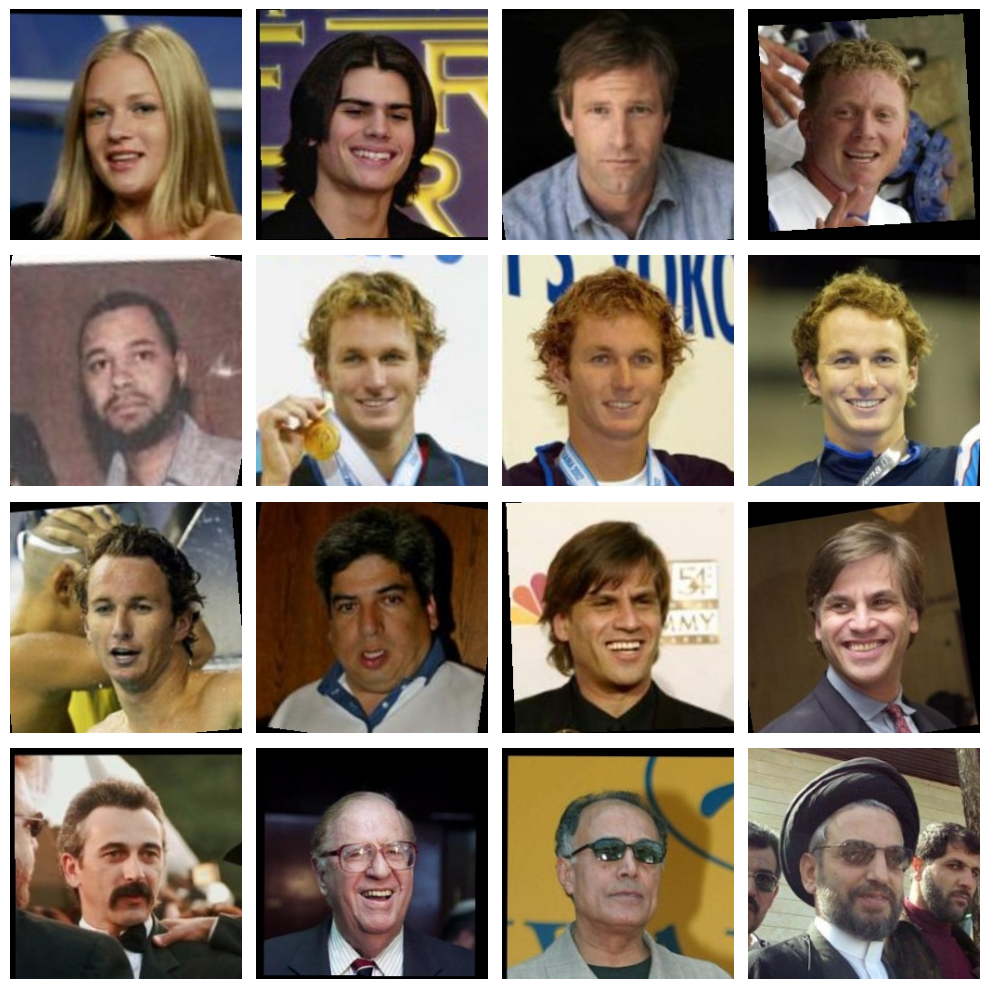

In [18]:
# Set up an 4x4 grid for 16 images in a batch
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
num_plots = 4 * 4 # Number of images to plot
# Loop over the dataloader
for batch in loader:
  # Get the batch of images and labels
  images, labels = batch
  # Loop over image in a batch
  for j in range(batch_size):
    img = torch.permute(images[j], (1, 2, 0)) # (C, H, W) -> (H, W, C)
    row = j // 4 # Row idx for subplot
    col = j % 4 # Col idx for sublplot
    ax[row, col].imshow(img)
    ax[row, col].axis('off')
    if j >= num_plots - 1:
      break # Stop after plotting specified number of images

  break

plt.tight_layout()
plt.show()


# Data Preprocessing: MTCNN for Face Detection and Cropping

In [19]:
mtcnn = MTCNN(keep_all=True, device=device)

In [21]:
def apply_mtcnn_crop(images: torch.Tensor, target_size=(128, 128)) -> torch.Tensor:
  """
  Function to apply MTCNN face detection and crop the images in a batch.

  Args:
      images (torch.Tensor): A batch of images of shape (batch_size, C, H, W).
      target_size (tuple): A target_size (H, W) to resize to after cropping.

  Returns:
      torch.Tensor: A batch of cropped images.

  """
  # Convert tensor batch to PIL images
  images_pil = [transforms.ToPILImage()(img) for images in images]

  cropped_images = []

  for img_pil in images_pil:
    boxes, _ = mtcnn.detect(img_pil) # Detect faces with MTCNN
    if boxes is not None:
      # Crop the image using first detected bounding box
      x1, y1, x2, y2 = boxes[0].tolist()
      img_pil = img_pil.crop((x1, y1, x2, y2))
    # Resize the image to target_size
    img_pil = img_pil.resize(target_size)
    # Convert cropped image back to tensor (if cropped)
    img_tensor = transforms.ToTensor()(img_pil)
    cropped_images.append(img_tensor)

  # Stack the cropped images into a single tensor
  return torch.stack(cropped_images)

## MTCNN Preprocessed Dataset (So we can add our images later!)

In [22]:
class MTCNNPreprocessedDataset(Dataset):
  def __init__(self, original_dataset, target_size=(128, 128), transform=None):
    """
    Args:
        original_dataset (Dataset): The original dataset to use (eg. a standard ImageFolder).
        target_size (tuple): The target size for resized images.
        transforms (callable, optional): Optional transform to be applied on a sample.
    """
    self.original_dataset = original_dataset
    self.target_size = target_size
    self.transform = transform

    # Preprocess the images during Initialization
    self.images = []
    self.labels = []
    self._preprocess_images()

  def __len__(self):
    return len(self.original_dataset)

  def __getitem__(self, idx):
    """
    Return Preprocessed image and it's label.
    """
    img, label = self.images[idx], self.labels[idx]

    # Apply additional transformations if provided (eg. Normalization)
    if self.transform:
      img = self.transform(img)

    return img, label

  def apply_mtcnn_crop(self, img: Image.Image):
    """
    Apply MTCNN Face Detection, Crop and Resize the image.

    Args:
        img (PIL.Image.Image): The input image.

    Returns:
        PIL.Image.Image: The cropped and resized image.
    """
    boxes, _ = mtcnn.detect(img) # Detect faces with MTCNN
    if boxes is not None:
      # Crop the image using first detected bounding box
      x1, y1, x2, y2 = boxes[0].tolist()
      img = img.crop((x1, y1, x2, y2))
    # Resize the image to target_size
    img = img.resize(self.target_size)

    return img

  def _preprocess_images(self):
    """
    Apply MTCNN Face Detection, Crop and Resize all the images in the dataset.
    """
    print("Cropping images with MTCNN: ")
    for idx in tqdm(range(len(self.original_dataset))):
      img, label = self.original_dataset[idx] # Get the image and label from original dataset
      img = self.apply_mtcnn_crop(img) # Apply MTCNN Crop
      self.images.append(img)
      self.labels.append(label)

## Create a MTCNN_Preprocessed dataset/dataLoader

In [23]:
# transform: Convert to Tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create a custim MTCNN Prepreocessed dataset
mtcnn_preprocessed_dataset = MTCNNPreprocessedDataset(dataset, target_size=(128, 128), transform=transform)

# Create a dataloader for preprocessed images
batch_size = 1024
mtcnn_preprocessed_loader = DataLoader(mtcnn_preprocessed_dataset, batch_size=batch_size, shuffle=True)

Cropping images with MTCNN: 


100%|██████████| 13233/13233 [22:49<00:00,  9.67it/s]


## Plot Cropped Face Images detected by MTCNN

Number of batches:  13


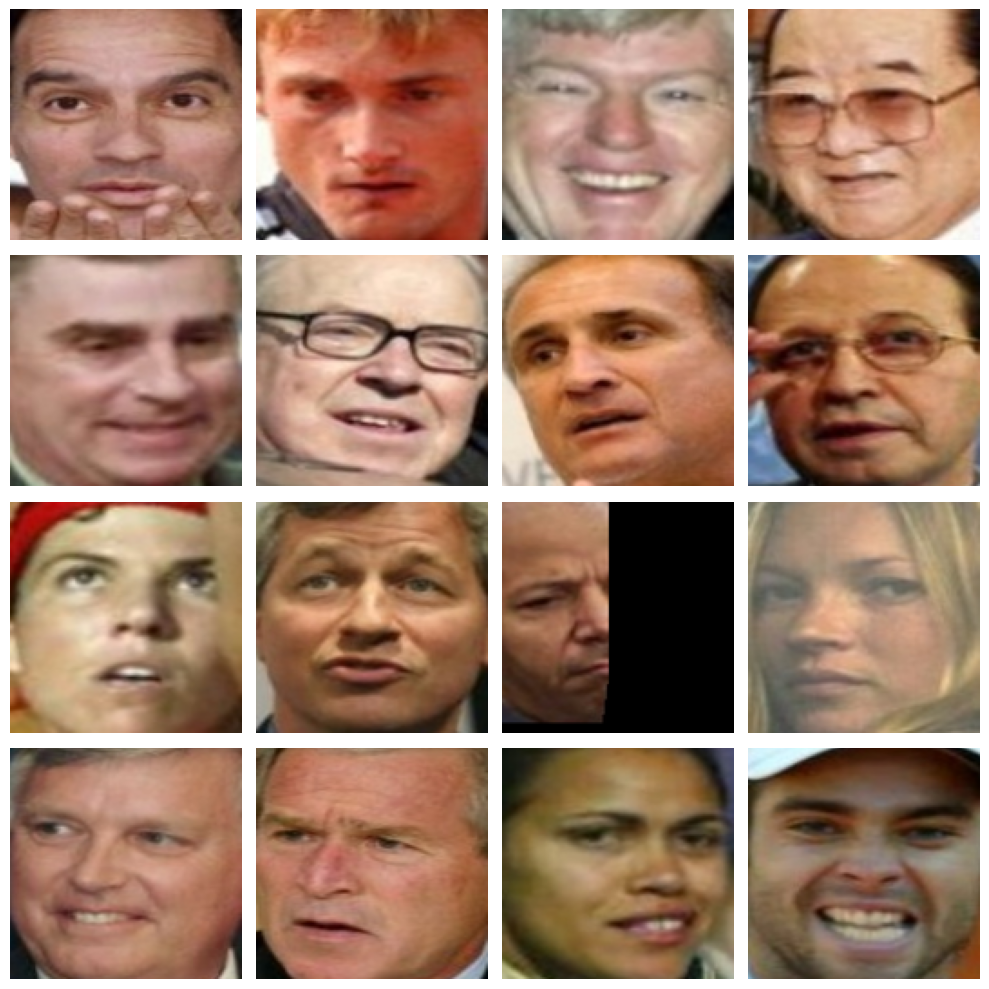

In [24]:
# Print Number of batches and shape of each batch
print("Number of batches: ", len(mtcnn_preprocessed_loader))

# Set up an 4x4 grid for 16 images in a batch
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
num_plots = 4 * 4 # Number of images to plot
# Loop over the dataloader
for batch in mtcnn_preprocessed_loader:
  # Get the batch of images and labels
  images, labels = batch
  # Loop over image in a batch
  for j in range(batch_size):
    img = torch.permute(images[j], (1, 2, 0)) # (C, H, W) -> (H, W, C)
    row = j // 4 # Row idx for subplot
    col = j % 4 # Col idx for sublplot
    ax[row, col].imshow(img)
    ax[row, col].axis('off')
    if j >= num_plots - 1:
      break # Stop after plotting specified number of images

  break

plt.tight_layout()
plt.show()


# The AutoEncoder (AE)

In [32]:
class Autoencoder(nn.Module):
  def __init__(self, in_ch=3, ndf=32, latent_space_size=256):
    super(Autoencoder, self).__init__()

    self.latent_space_size = latent_space_size
    self.ndf = ndf

    # Encoders: Convolutional layers to extract features
    # [batch_size, 3, 128, 128] -> [batch_size, ndf, 64, 64]
    # [batch_size, ndf, 64, 64] -> [batch_size, ndf*2, 32, 32]
    # [batch_size, ndf*2, 32, 32] -> [batch_size, ndf*4, 16, 16]
    # [batch_size, ndf*4, 16, 16] -> [batch_size, ndf*8, 8, 8]
    self.encoder = nn.Sequential(
        nn.Conv2d(in_ch, ndf, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(ndf),
        nn.LeakyReLU(),
        nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(ndf*2),
        nn.LeakyReLU(),
        nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(ndf*4),
        nn.LeakyReLU(),
        nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(ndf*8),
        nn.LeakyReLU()
    )

    # Latent space size
    # FC layer to output latent vector
    # Fully Connected to latent space
    self.flattened_size = ndf*8*8*8
    self.fc = nn.Linear(self.flattened_size, self.latent_space_size)

    # Decoder: Convolutional Transpose layers (Deconvolution)
    self.fc_decode = nn.Linear(self.latent_space_size, self.flattened_size)

    # [batch_size, ndf*8, 8, 8] -> [batch_size, ndf*4, 16, 16]
    # [batch_size, ndf*4, 16, 16] -> [batch_size, ndf*2, 32, 32]
    # [batch_size, ndf*2, 32, 32] -> [batch_size, ndf, 64, 64]
    # [batch_size, ndf, 64, 64] -> [batch_size, in_ch, 128, 128]
    self.decoder = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        nn.Conv2d(ndf*8, ndf*4, kernel_size=3, stride=1, padding=1),
        nn.InstanceNorm2d(ndf*4),
        nn.LeakyReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        nn.Conv2d(ndf*4, ndf*2, kernel_size=3, stride=1, padding=1),
        nn.InstanceNorm2d(ndf*2),
        nn.LeakyReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        nn.Conv2d(ndf*2, ndf, kernel_size=3, stride=1, padding=1),
        nn.InstanceNorm2d(ndf),
        nn.LeakyReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        nn.Conv2d(ndf, in_ch, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid()
    )

  def encode(self, x: torch.Tensor) -> torch.Tensor:
    """
    Encodes the input image into latent representation.

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, 3, 128, 128).

    Returns:
        : Latent Representation with shape (batch_size, latent_space_size).
    """

    x = self.encoder(x) # Output shape (batch_size, ndf*8, 8, 8)
    x = torch.flatten(x, 1) # Flatten the output
    return self.fc(x)

  def decode(self, z: torch.Tensor) -> torch.Tensor:
    """
    Decode the latent space representation back into reconstructed image.

    Args:
        z (torch.Tensor): latent space tensor with shape (batch_size, latent_space_size).

    Returns:
        : Reconstructed image tensor with shape (batch_shape, 3, 128, 128).
    """
    z = self.fc_decode(z) # Output shape (batch_shape, flattened_size)
    z = torch.reshape(z, (z.size(0), self.ndf*8, 8, 8)) # Reshape
    return self.decoder(z)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """
    Forward pass: Encodes and Decodes the input image.

    Args:
        x (torch.Tensor): Input image tensor with shape (batch_size, 3, 128, 128).

    Returns:
        : Reconstructed image tensor with shape (batch_size, 3, 128, 128).
    """
    latent = self.encode(x)
    decoded = self.decode(latent)
    return decoded

  def loss_function(self, recon_x: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    """
    Calculates the AutoEncoder loss, which consists of reconstruction loss(BCE).

    Args:
        recon_x (torch.Tensor): Reconstructed image tensor of shape (batch_size, 3, 128, 128).
        x (torch.Tensor): Original image tensor of shape (batch_size, 3, 128, 128).

    Returns:
        : Total Loss value (BCE loss).
    """
    # Reconstruction loss (BCE loss w logits, sigmoid is applied)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    return recon_loss


In [33]:
# Instantiate the AutoEncoder
AE_model = Autoencoder().to(device)
summary(AE_model, input_size =(batch_size, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1024, 3, 128, 128]       --
├─Sequential: 1-1                        [1024, 256, 8, 8]         --
│    └─Conv2d: 2-1                       [1024, 32, 64, 64]        1,568
│    └─InstanceNorm2d: 2-2               [1024, 32, 64, 64]        --
│    └─LeakyReLU: 2-3                    [1024, 32, 64, 64]        --
│    └─Conv2d: 2-4                       [1024, 64, 32, 32]        32,832
│    └─InstanceNorm2d: 2-5               [1024, 64, 32, 32]        --
│    └─LeakyReLU: 2-6                    [1024, 64, 32, 32]        --
│    └─Conv2d: 2-7                       [1024, 128, 16, 16]       131,200
│    └─InstanceNorm2d: 2-8               [1024, 128, 16, 16]       --
│    └─LeakyReLU: 2-9                    [1024, 128, 16, 16]       --
│    └─Conv2d: 2-10                      [1024, 256, 8, 8]         524,544
│    └─InstanceNorm2d: 2-11              [1024, 256, 8, 8]         -

# The Variational AutoEncoder (VAE)

In [34]:
class VariationalAutoencoder(nn.Module):
  def __init__(self, in_ch=3, ndf=32, latent_space_size=256):
    super(VariationalAutoencoder, self).__init__()

    self.latent_space_size = latent_space_size
    self.ndf = ndf

    # Encoders: Convolutional layers to extract features
    # [batch_size, 3, 128, 128] -> [batch_size, ndf, 64, 64]
    # [batch_size, ndf, 64, 64] -> [batch_size, ndf*2, 32, 32]
    # [batch_size, ndf*2, 32, 32] -> [batch_size, ndf*4, 16, 16]
    # [batch_size, ndf*4, 16, 16] -> [batch_size, ndf*8, 8, 8]
    self.encoder = nn.Sequential(
        nn.Conv2d(in_ch, ndf, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(ndf),
        nn.LeakyReLU(),
        nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(ndf*2),
        nn.LeakyReLU(),
        nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(ndf*4),
        nn.LeakyReLU(),
        nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(ndf*8),
        nn.LeakyReLU()
    )
    # Latent space size (for VAE, we need mu and log_var of the latent distribution)
    self.flattened_size = ndf*8*8*8

    # FC layer to output mean and log variance for the latent space
    self.fc_mu = nn.Linear(self.flattened_size, self.latent_space_size)
    self.fc_log_var = nn.Linear(self.flattened_size, self.latent_space_size)

    # Decoder: Convolutional Transpose layers (Deconvolution)
    self.fc_decode = nn.Linear(self.latent_space_size, self.flattened_size)

    # [batch_size, ndf*8, 8, 8] -> [batch_size, ndf*4, 16, 16]
    # [batch_size, ndf*4, 16, 16] -> [batch_size, ndf*2, 32, 32]
    # [batch_size, ndf*2, 32, 32] -> [batch_size, ndf, 64, 64]
    # [batch_size, ndf, 64, 64] -> [batch_size, in_ch, 128, 128]
    self.decoder = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        nn.Conv2d(ndf*8, ndf*4, kernel_size=3, stride=1, padding=1),
        nn.InstanceNorm2d(ndf*4),
        nn.LeakyReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        nn.Conv2d(ndf*4, ndf*2, kernel_size=3, stride=1, padding=1),
        nn.InstanceNorm2d(ndf*2),
        nn.LeakyReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        nn.Conv2d(ndf*2, ndf, kernel_size=3, stride=1, padding=1),
        nn.InstanceNorm2d(ndf),
        nn.LeakyReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        nn.Conv2d(ndf, in_ch, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid()
    )

  def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Encodes the input image into latent distribution (mean and log variance).

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, 3, 128, 128).

    Returns:
        : mean (mu) and log variance (log_var) tensors with shape (batch_size, latent_space_size).
    """

    x = self.encoder(x) # Output shape (batch_size, ndf*8, 8, 8)
    x = torch.flatten(x, 1) # Flatten the output
    mu = self.fc_mu(x) # Mean of latent space (batch_size, latent_space_size)
    log_var = self.fc_log_var(x) # Log variance od latent space (batch_size, latent_space_size)
    return mu, log_var

  def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
    """
    Reparameterization trick: Sample z from N(mu, sigma^2) using mu and log_var.

    Args:
        mu (torch.Tensor): Mean of latent space woth shape (batch_size, latent_space_size).
        log_var (torch.Tensor): Log variance of latent space with shape (batch_size, latent_space_size).

    Returns:
        : Latent vector z sampled from N(mu, sigma^2).
    """
    std = torch.exp(0.5 * log_var) # Standard deviation from log_var
    eps = torch.randn_like(std) # Sample from N(0, 1)
    return mu + eps * std

  def decode(self, z: torch.Tensor) -> torch.Tensor:
    """
    Decode the latent space representation back into reconstructed image.

    Args:
        z (torch.Tensor): latent space tensor with shape (batch_size, latent_space_size).

    Returns:
        : Reconstructed image tensor with shape (batch_shape, 3, 128, 128).
    """
    z = self.fc_decode(z) # Output shape (batch_shape, flattened_size)
    z = torch.reshape(z, (z.size(0), self.ndf*8, 8, 8)) # Reshape
    return self.decoder(z)

  def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Forward pass: Encodes the input, Applies reparametrization trick and decodes.

    Args:
        x (torch.Tensor): Input image tensor with shape (batch_size, 3, 128, 128).

    Returns:
        : Reconstructed image tensor with shape (batch_size, 3, 128, 128).
        mu (torch.Tensor): Mean of latent space woth shape (batch_size, latent_space_size).
        log_var (torch.Tensor): Log variance of latent space with shape (batch_size, latent_space_size).
    """
    mu, log_var = self.encode(x)
    z = self.reparameterize(mu, log_var)
    decoded = self.decode(z)
    return decoded, mu, log_var

  def loss_function(self, recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, log_var: torch.Tensor, kl_weight: float=0.00025) -> torch.Tensor:
    """
    Calculates the VAE loss, which is sum of reconstruction loss and KL divergence.

    Args:
        recon_x (torch.Tensor): Reconstructed image tensor of shape (batch_size, 3, 128, 128).
        x (torch.Tensor): Original image tensor of shape (batch_size, 3, 128, 128).
        mu (torch.Tensor): Mean of latent space woth shape (batch_size, latent_space_size).
        log_var (torch.Tensor): Log variance of latent space with shape (batch_size, latent_space_size).
        kl_weight (float): Weight of the KL divergence term.
    Returns:
        : Total VAE Loss value.
    """
    # Reconstruction loss (BCE loss)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence between learned distribution and standard Normal distribution
    kl_div = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp())

    # Total VAE loss is the sum of reconstruction loss and KL divergence
    return recon_loss + kl_weight * kl_div


In [37]:
# Instantiate the Variational AutoEncoder
VAE_model = VariationalAutoencoder().to(device)
summary(VAE_model, input_size=(batch_size, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
VariationalAutoencoder                   [1024, 3, 128, 128]       --
├─Sequential: 1-1                        [1024, 256, 8, 8]         --
│    └─Conv2d: 2-1                       [1024, 32, 64, 64]        1,568
│    └─InstanceNorm2d: 2-2               [1024, 32, 64, 64]        --
│    └─LeakyReLU: 2-3                    [1024, 32, 64, 64]        --
│    └─Conv2d: 2-4                       [1024, 64, 32, 32]        32,832
│    └─InstanceNorm2d: 2-5               [1024, 64, 32, 32]        --
│    └─LeakyReLU: 2-6                    [1024, 64, 32, 32]        --
│    └─Conv2d: 2-7                       [1024, 128, 16, 16]       131,200
│    └─InstanceNorm2d: 2-8               [1024, 128, 16, 16]       --
│    └─LeakyReLU: 2-9                    [1024, 128, 16, 16]       --
│    └─Conv2d: 2-10                      [1024, 256, 8, 8]         524,544
│    └─InstanceNorm2d: 2-11              [1024, 256, 8, 8]         -